In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
import tensorflow as tf
import random
import os
import random
import numpy as np

seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

Dane opisują klientów firmy telekomunikacyjnej. Klienci używają tzw. produktów pre-paid i często zmieniają operatora(około 1.5% klientów zmienia operatora miesięcznie) - proces ten nazywa się *churnem*.

Firma jest zainteresowana segmentacją klientów w celu podjęcia ewentualnej opcji "utrzymaniowej".

In [ ]:
import pandas as pd
df = pd.read_excel('/churn.xlsx')
df = df.drop(['ID'], axis=1)

# **1. Przygotowanie danych.**

In [ ]:
df.head()

,"Churn (1=yes, 0=No)",Profit,Age,Cancelled,Months since start,Way of payment,Promotion,Region,Profit segment,Sex,Tariff model,Academic title,Revenue from calls (3 months ago),Fixed revenue (3 months ago),Revenue from roaming (3 months ago),Total revenue (3 months ago),Airtime to data service (1 month ago),Airtime incoming (1 month ago),Airtime to mobile (1 month ago),Calls to data service (3 months ago),Calls incoming (3 months ago),Calls roaming (3 months ago)
0,0,25.409096,21,0,14,Standing Order,0,0,D,Female,5,0,7.827187,0.00,0.0,7.827187,0.0,1105.413331,439.863154,0,75,0
1,1,572.107602,29,0,26,Standing Order,0,7,B,Male,8,0,436.528877,0.00,0.0,436.528877,0.0,54991.234822,44696.346418,0,199,3
2,0,57.456634,20,0,10,Standing Order,0,1,D,Female,5,0,69.884354,28.12,0.0,98.004354,0.0,684.385557,651.221462,0,54,0
3,1,292.595896,47,1,29,Standing Order,0,5,A,Male,18,0,419.516818,62.60,0.0,482.116818,0.0,12523.260237,4837.449854,0,134,0
4,0,6.599228,47,0,10,Standing Order,0,7,D,Male,8,0,12.092878,0.00,0.0,12.092878,0.0,2531.737199,73.926074,0,21,0


In [ ]:
df.describe()

,"Churn (1=yes, 0=No)",Profit,Age,Cancelled,Months since start,Promotion,Tariff model,Academic title,Revenue from calls (3 months ago),Fixed revenue (3 months ago),Revenue from roaming (3 months ago),Total revenue (3 months ago),Airtime to data service (1 month ago),Airtime incoming (1 month ago),Airtime to mobile (1 month ago),Calls to data service (3 months ago),Calls incoming (3 months ago),Calls roaming (3 months ago)
count,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.0,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.0,11810.000000,11810.000000
mean,0.100000,101.098452,28.219306,0.020237,16.807790,0.0,10.215072,0.024555,51.729468,28.688493,8.611292,89.029253,0.087792,2918.518792,1137.365030,0.0,35.549958,0.611262
std,0.300013,209.927808,6.590383,0.140816,9.520886,0.0,5.606525,0.154772,105.807331,11.855100,45.855806,121.132813,3.023441,5246.237369,3272.294606,0.0,51.172809,2.939251
min,0.000000,0.000000,20.000000,0.000000,6.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,26.062782,24.000000,0.000000,10.000000,0.0,5.000000,0.000000,6.920331,28.120000,0.000000,36.048499,0.000000,155.317780,0.000000,0.0,4.000000,0.000000
50%,0.000000,61.802175,27.000000,0.000000,14.000000,0.0,8.000000,0.000000,21.319532,28.120000,0.000000,54.066947,0.000000,878.190495,147.513869,0.0,17.000000,0.000000
75%,0.000000,113.761592,31.000000,0.000000,22.000000,0.0,16.000000,0.000000,57.896985,30.710000,0.000000,100.208620,0.000000,3534.272460,911.889711,0.0,47.000000,0.000000
max,1.000000,11541.527297,50.000000,1.000000,71.000000,0.0,18.000000,1.000000,2843.420175,65.190000,990.817981,2874.130175,116.934334,64615.684971,56154.459996,0.0,643.000000,46.000000


Nazwy kolumn zostają zmienione na bardziej użyteczne.

In [ ]:
dict_column = {
               'Churn (1=yes, 0=No)':'churn',
               'Profit':'profit',
               'Age':'age',
               'Way of payment': 'way_of_payment',
               'Region': 'region',
               'Profit segment': 'profit_segment',
               'Sex': 'sex',
               'Cancelled': 'cancelled',
               'Months since start': 'months_start',
               'Promotion': 'promotion',
               'Tariff model': 'tariff_model',
               'Academic title': 'academic_title',
               'Revenue from calls (3 months ago)': 'revenue_calls_3_months_ago',
               'Fixed revenue (3 months ago)': 'fixed_revenue_3_months_ago',
               'Revenue from roaming (3 months ago)': 'revenue_roaming_3_months_ago',
               'Total revenue (3 months ago)': 'total_revenue_3_months_ago',
               'Airtime to data service (1 month ago)': 'airtime_to_data_service_1_month_ago',
               'Airtime incoming (1 month ago)': 'airtime_incoming_1_month_ago',
               'Airtime to mobile (1 month ago)': 'airtime_to_mobile_1_month_ago',
               'Calls to data service (3 months ago)': 'calls_to_data_service_3_months_ago',
               'Calls incoming (3 months ago)': 'calls_incoming_3_months_ago',
               'Calls roaming (3 months ago)': 'calls_roaming_3_months_ago'
               }
df = df.rename(columns=dict_column)
df.head()

,churn,profit,age,cancelled,months_start,way_of_payment,promotion,region,profit_segment,sex,tariff_model,academic_title,revenue_calls_3_months_ago,fixed_revenue_3_months_ago,revenue_roaming_3_months_ago,total_revenue_3_months_ago,airtime_to_data_service_1_month_ago,airtime_incoming_1_month_ago,airtime_to_mobile_1_month_ago,calls_to_data_service_3_months_ago,calls_incoming_3_months_ago,calls_roaming_3_months_ago
0,0,25.409096,21,0,14,Standing Order,0,0,D,Female,5,0,7.827187,0.00,0.0,7.827187,0.0,1105.413331,439.863154,0,75,0
1,1,572.107602,29,0,26,Standing Order,0,7,B,Male,8,0,436.528877,0.00,0.0,436.528877,0.0,54991.234822,44696.346418,0,199,3
2,0,57.456634,20,0,10,Standing Order,0,1,D,Female,5,0,69.884354,28.12,0.0,98.004354,0.0,684.385557,651.221462,0,54,0
3,1,292.595896,47,1,29,Standing Order,0,5,A,Male,18,0,419.516818,62.60,0.0,482.116818,0.0,12523.260237,4837.449854,0,134,0
4,0,6.599228,47,0,10,Standing Order,0,7,D,Male,8,0,12.092878,0.00,0.0,12.092878,0.0,2531.737199,73.926074,0,21,0


Sprawdzenie, czy tablica zawiera wartość null.

In [ ]:
df.isnull().sum()

churn                                  0
profit                                 0
age                                    0
cancelled                              0
months_start                           0
way_of_payment                         0
promotion                              0
region                                 0
profit_segment                         0
sex                                    0
tariff_model                           0
academic_title                         0
revenue_calls_3_months_ago             0
fixed_revenue_3_months_ago             0
revenue_roaming_3_months_ago           0
total_revenue_3_months_ago             0
airtime_to_data_service_1_month_ago    0
airtime_incoming_1_month_ago           0
airtime_to_mobile_1_month_ago          0
calls_to_data_service_3_months_ago     0
calls_incoming_3_months_ago            0
calls_roaming_3_months_ago             0
dtype: int64

Utworzenie macierzy korelacji i sprawdzenie, czy są zmienne, które należy usunąć.

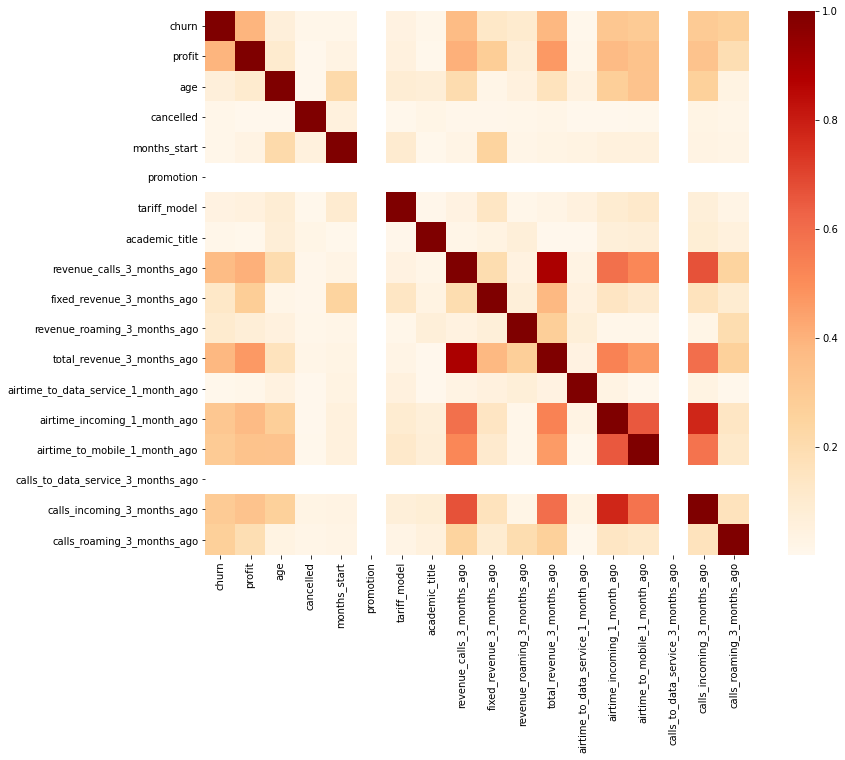

In [ ]:
correlation_matrix = df.corr(method = "spearman").abs()

fig = plt.figure(figsize=(14,10))
sns.heatmap(correlation_matrix, cmap='OrRd', square=True)
plt.show()

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

Zmienne "Total revenue (3 months ago)" i "Revenue from calls" mają wysoką korelację, więc jedną z nich można usunąć.

In [ ]:
df_after_correlation = df.drop(to_drop, axis=1)

In [ ]:
df.head()

,churn,profit,age,cancelled,months_start,way_of_payment,promotion,region,profit_segment,sex,tariff_model,academic_title,revenue_calls_3_months_ago,fixed_revenue_3_months_ago,revenue_roaming_3_months_ago,total_revenue_3_months_ago,airtime_to_data_service_1_month_ago,airtime_incoming_1_month_ago,airtime_to_mobile_1_month_ago,calls_to_data_service_3_months_ago,calls_incoming_3_months_ago,calls_roaming_3_months_ago
0,0,25.409096,21,0,14,Standing Order,0,0,D,Female,5,0,7.827187,0.00,0.0,7.827187,0.0,1105.413331,439.863154,0,75,0
1,1,572.107602,29,0,26,Standing Order,0,7,B,Male,8,0,436.528877,0.00,0.0,436.528877,0.0,54991.234822,44696.346418,0,199,3
2,0,57.456634,20,0,10,Standing Order,0,1,D,Female,5,0,69.884354,28.12,0.0,98.004354,0.0,684.385557,651.221462,0,54,0
3,1,292.595896,47,1,29,Standing Order,0,5,A,Male,18,0,419.516818,62.60,0.0,482.116818,0.0,12523.260237,4837.449854,0,134,0
4,0,6.599228,47,0,10,Standing Order,0,7,D,Male,8,0,12.092878,0.00,0.0,12.092878,0.0,2531.737199,73.926074,0,21,0


Przekształcanie danych kategorycznych na dane nominalne w Sex

In [ ]:
df_after_correlation['sex'] = pd.factorize(df_after_correlation['sex'])[0]
df_after_correlation.sex.value_counts()

1    8970
0    2840
Name: sex, dtype: int64

Przekształcanie danych kategorycznych na dane nominalne w way_of_payment

In [ ]:
df_after_correlation['way_of_payment'] = pd.factorize(df_after_correlation['way_of_payment'])[0]
df_after_correlation.way_of_payment.value_counts()

0    11270
1      540
Name: way_of_payment, dtype: int64

Przekształcanie danych kategorycznych na dane nominalne w profit_segment

In [ ]:
df_after_correlation['profit_segment'] = pd.factorize(df_after_correlation['profit_segment'])[0]
df_after_correlation.profit_segment.value_counts()

0    7140
3    2240
4    1360
1     910
2     160
Name: profit_segment, dtype: int64

Jest to wyjątek, ponieważ w kolumnie, mimo że występowały wartości liczbowe, występował parametr "F". Dla wygody 'F' zostaje przekształcone w int.


In [ ]:
df_after_correlation['region'] = pd.factorize(df_after_correlation['region'])[0]
df_after_correlation.region.value_counts()

3     1960
5     1420
1     1320
6     1300
9     1240
7     1070
4     1050
8     1000
2      850
0      580
10      20
Name: region, dtype: int64

Wszystkie zmienne są reprezentowane w postaci liczbowej, co pozwala na zastosowanie większej ilości modeli uczenia maszynowego, ponieważ niektóre z nich nie rozumieją danych typu string.

In [ ]:
df_after_correlation.head()

,churn,profit,age,cancelled,months_start,way_of_payment,promotion,region,profit_segment,sex,tariff_model,academic_title,revenue_calls_3_months_ago,fixed_revenue_3_months_ago,revenue_roaming_3_months_ago,airtime_to_data_service_1_month_ago,airtime_incoming_1_month_ago,airtime_to_mobile_1_month_ago,calls_to_data_service_3_months_ago,calls_incoming_3_months_ago,calls_roaming_3_months_ago
0,0,25.409096,21,0,14,0,0,0,0,0,5,0,7.827187,0.00,0.0,0.0,1105.413331,439.863154,0,75,0
1,1,572.107602,29,0,26,0,0,1,1,1,8,0,436.528877,0.00,0.0,0.0,54991.234822,44696.346418,0,199,3
2,0,57.456634,20,0,10,0,0,2,0,0,5,0,69.884354,28.12,0.0,0.0,684.385557,651.221462,0,54,0
3,1,292.595896,47,1,29,0,0,3,2,1,18,0,419.516818,62.60,0.0,0.0,12523.260237,4837.449854,0,134,0
4,0,6.599228,47,0,10,0,0,1,0,1,8,0,12.092878,0.00,0.0,0.0,2531.737199,73.926074,0,21,0


In [ ]:
df_after_correlation.describe()

,churn,profit,age,cancelled,months_start,way_of_payment,promotion,region,profit_segment,sex,tariff_model,academic_title,revenue_calls_3_months_ago,fixed_revenue_3_months_ago,revenue_roaming_3_months_ago,airtime_to_data_service_1_month_ago,airtime_incoming_1_month_ago,airtime_to_mobile_1_month_ago,calls_to_data_service_3_months_ago,calls_incoming_3_months_ago,calls_roaming_3_months_ago
count,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.0,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.0,11810.000000,11810.000000
mean,0.100000,101.098452,28.219306,0.020237,16.807790,0.045724,0.0,4.644369,1.133785,0.759526,10.215072,0.024555,51.729468,28.688493,8.611292,0.087792,2918.518792,1137.365030,0.0,35.549958,0.611262
std,0.300013,209.927808,6.590383,0.140816,9.520886,0.208895,0.0,2.692128,1.547745,0.427390,5.606525,0.154772,105.807331,11.855100,45.855806,3.023441,5246.237369,3272.294606,0.0,51.172809,2.939251
min,0.000000,0.000000,20.000000,0.000000,6.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,26.062782,24.000000,0.000000,10.000000,0.000000,0.0,3.000000,0.000000,1.000000,5.000000,0.000000,6.920331,28.120000,0.000000,0.000000,155.317780,0.000000,0.0,4.000000,0.000000
50%,0.000000,61.802175,27.000000,0.000000,14.000000,0.000000,0.0,5.000000,0.000000,1.000000,8.000000,0.000000,21.319532,28.120000,0.000000,0.000000,878.190495,147.513869,0.0,17.000000,0.000000
75%,0.000000,113.761592,31.000000,0.000000,22.000000,0.000000,0.0,7.000000,3.000000,1.000000,16.000000,0.000000,57.896985,30.710000,0.000000,0.000000,3534.272460,911.889711,0.0,47.000000,0.000000
max,1.000000,11541.527297,50.000000,1.000000,71.000000,1.000000,0.0,10.000000,4.000000,1.000000,18.000000,1.000000,2843.420175,65.190000,990.817981,116.934334,64615.684971,56154.459996,0.0,643.000000,46.000000


Dane zostają przetworzone przy użyciu MinMaxScaler.

In [ ]:
X = df_after_correlation.drop(['churn'], axis=1)
y = df_after_correlation.churn
X.head()

,profit,age,cancelled,months_start,way_of_payment,promotion,region,profit_segment,sex,tariff_model,academic_title,revenue_calls_3_months_ago,fixed_revenue_3_months_ago,revenue_roaming_3_months_ago,airtime_to_data_service_1_month_ago,airtime_incoming_1_month_ago,airtime_to_mobile_1_month_ago,calls_to_data_service_3_months_ago,calls_incoming_3_months_ago,calls_roaming_3_months_ago
0,25.409096,21,0,14,0,0,0,0,0,5,0,7.827187,0.00,0.0,0.0,1105.413331,439.863154,0,75,0
1,572.107602,29,0,26,0,0,1,1,1,8,0,436.528877,0.00,0.0,0.0,54991.234822,44696.346418,0,199,3
2,57.456634,20,0,10,0,0,2,0,0,5,0,69.884354,28.12,0.0,0.0,684.385557,651.221462,0,54,0
3,292.595896,47,1,29,0,0,3,2,1,18,0,419.516818,62.60,0.0,0.0,12523.260237,4837.449854,0,134,0
4,6.599228,47,0,10,0,0,1,0,1,8,0,12.092878,0.00,0.0,0.0,2531.737199,73.926074,0,21,0


Standaryzacja danych.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(X))
scaled_data.columns = X.columns
X = scaled_data
X.head()

,profit,age,cancelled,months_start,way_of_payment,promotion,region,profit_segment,sex,tariff_model,academic_title,revenue_calls_3_months_ago,fixed_revenue_3_months_ago,revenue_roaming_3_months_ago,airtime_to_data_service_1_month_ago,airtime_incoming_1_month_ago,airtime_to_mobile_1_month_ago,calls_to_data_service_3_months_ago,calls_incoming_3_months_ago,calls_roaming_3_months_ago
0,-0.360565,-1.095477,-0.143719,-0.294921,-0.218895,0.0,-1.725240,-0.732571,-1.777203,-0.930218,-0.158662,-0.414944,-2.420031,-0.187799,-0.029038,-0.345616,-0.213163,0.0,0.770951,-0.207974
1,2.243767,0.118465,-0.143719,0.965519,-0.218895,0.0,-1.353771,-0.086442,0.562682,-0.395105,-0.158662,3.636947,-2.420031,-0.187799,-0.029038,9.926147,13.312012,0.0,3.194215,0.812737
2,-0.207898,-1.247219,-0.143719,-0.715068,-0.218895,0.0,-0.982301,-0.732571,-1.777203,-0.930218,-0.158662,0.171592,-0.047955,-0.187799,-0.029038,-0.425872,-0.148570,0.0,0.360559,-0.207974
3,0.912245,2.849833,6.958033,1.280629,-0.218895,0.0,-0.610832,0.559686,0.562682,1.388607,-0.158662,3.476157,2.860620,-0.187799,-0.029038,1.830864,1.130779,0.0,1.923956,-0.207974
4,-0.450170,2.849833,-0.143719,-0.715068,-0.218895,0.0,-1.353771,-0.732571,0.562682,-0.395105,-0.158662,-0.374627,-2.420031,-0.187799,-0.029038,-0.073729,-0.324996,0.0,-0.284342,-0.207974


Rozdzielenie zbioru danych na testowy i treningowy.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

# **2. Budowa modeli klasyfikacyjnych.**

LDA.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def model_LDA(X_train, y_train):
  m_LDA = LDA()
  m_LDA.fit(X_train, y_train)
  return m_LDA

Xgboost.

In [ ]:
from xgboost import XGBClassifier

def model_xgboost(X_train, y_train):
  model_boost = XGBClassifier(random_state=seed_value)
  parameters = {
    'max_depth' : range(1, 10),
    'criterion' : ["entropy", "gini"]
  }

  output_model = GridSearchCV(model_boost, parameters, scoring="roc_auc")
  output_model.fit(X_train, y_train)

  return output_model

Decision tree.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

def model_decision_tree(X_train, y_train):
  parameters = {
      'max_depth' : range(1, 10), 
      'min_samples_split' : [0.1, 0.2],
      'criterion' : ["entropy", "gini"]
  }
                
  decision_tree_model = DecisionTreeClassifier(random_state=seed_value)
  output_model = GridSearchCV(decision_tree_model, parameters, scoring="roc_auc")
  output_model.fit(X_train, y_train)

  return output_model

Random forest.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
def model_random_forest(X_train, y_train):

  parameters = {
      'max_depth' : range(1, 10), 
      'min_samples_split' : [0.1, 0.2],
      'criterion' : ["entropy", "gini"]
  }

  model_random_forest = RandomForestClassifier(random_state=seed_value)
  output_model = GridSearchCV(model_random_forest, parameters, scoring="roc_auc")
  output_model.fit(X_train, y_train)
  return output_model

Ulepszona wersja xgboost.

In [ ]:
from xgboost import XGBClassifier

def advance_model_xgboost(X_train, y_train):
  model_boost = XGBClassifier(random_state=seed_value)
  parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth' : range(1, 10),
        'criterion' : ["entropy", "gini"]
  }

  output_model = GridSearchCV(model_boost, parameters, scoring="roc_auc")
  output_model.fit(X_train, y_train)

  return output_model

# **3. Porównanie wybranych modeli.**

Utworzenie modelu testowego w celu oszacowania wpływu zmiennych.

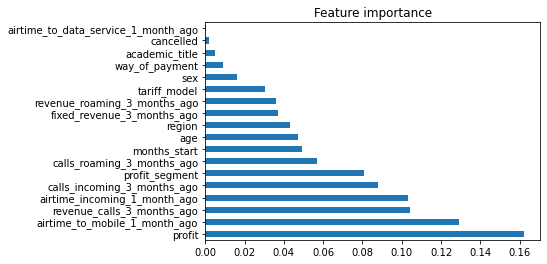

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(18).plot(kind='barh')
plt.title('Feature importance')
plt.show()

Z modelu badawczego wynika, że największy wpływ ma **profit**.

In [ ]:
def run_models(X_train, y_train):
  models = list()
  models.append(model_LDA(X_train, y_train))
  models.append(model_xgboost(X_train, y_train))
  models.append(model_decision_tree(X_train, y_train))
  models.append(model_random_forest(X_train, y_train))
  return models

models = run_models(X_train, y_train)

W celu oszacowania, jak dobrze modele radzą sobie z zadaniem, używamy krzywej auc.

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

def auc_score(model, X_test, y_test):
  probs = model.predict_proba(X_test)[:,1] > 0.5
  auc = roc_auc_score(y_test, probs)
  fpr, tpr, _ = roc_curve(y_test, probs)
  return fpr, tpr, auc

In [ ]:
auc_score_lda = auc_score(models[0], X_test, y_test)
auc_score_xgboost = auc_score(models[1], X_test, y_test)
auc_score_decision_tree = auc_score(models[2], X_test, y_test)
auc_score_random_forest = auc_score(models[3], X_test, y_test)

Budowa krzywej auc dla modeli.

In [ ]:
plt.plot(auc_score_lda[0], auc_score_lda[1], color='orange',
         label=f'AUC lda: {str(round(auc_score_lda[2], 2))}')

plt.plot(auc_score_xgboost[0], auc_score_xgboost[1], color='red',
         label=f'AUC xgboost: {str(round(auc_score_xgboost[2], 2))}')

plt.plot(auc_score_decision_tree[0], auc_score_decision_tree[1], color='green',
         label=f'AUC decison tree: {str(round(auc_score_decision_tree[2], 2))}')

plt.plot(auc_score_random_forest[0], auc_score_random_forest[1], color='blue',
         label=f'AUC random forest: {str(round(auc_score_random_forest[2], 2))}')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC CURVE')
plt.legend()

Po analizie krzywej auc, można stwierdzić, że xboost jest najlepszym modelem, więc model zostaje przetrenowany z większą ilością parametrów GridSearch.


**Uwaga!** Szkolenie trwało 3 godziny.

In [ ]:
advance_model_xgboost = advance_model_xgboost(X_train, y_train)

In [ ]:
auc_score_advance_xgboost = auc_score(advance_model_xgboost, X_test, y_test)

Porównanie wyników krzywej auc dla dwóch xboostów.

In [ ]:
plt.plot(auc_score_advance_xgboost[0], auc_score_advance_xgboost[1], color='green',
         label=f'AUC advance xgboost: {str(round(auc_score_advance_xgboost[2], 2))}')

plt.plot(auc_score_xgboost[0], auc_score_xgboost[1], color='red',
         label=f'AUC xgboost: {str(round(auc_score_xgboost[2], 2))}')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC CURVE')
plt.legend()

In [ ]:
y_pred_model = advance_model_xgboost.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred_model)

fig, ax = plot_confusion_matrix(conf_mat=cf_matrix, cmap="flag")
plt.title("Matrix Confusion")
plt.show()

# **4. Dyskusja.**
Do wykonania zadania wykorzystane zostały 4 różne algorytmy nauczania maszynowego(LDA, xboost, decision tree, random forest). Po treningu z użyciem auc score stwierdzono, że model wytrenowany na xboost był wystarczająco dobry(0.89 auc score), aby użyć go na tych danych. Pozostałe modele dawały zadowalające wyniki gorsze o około 0.15 w porównaniu z xboost.  Tak wysoki wynik auc może wskazywać, że sieć została przeszkolona dla zestawu danych treningowych.

Dlatego stworzony został model oparty na algorytmie xboost. Lista hiper parametrów została rozszerzona, co wpłynęło na czas treningu, który wzrósł z około 5 minut do około 3 godzin. W rezultacie wynik auc wzrósł o 0.02 i wyniósł 0.91. Wynik jest wysoki i również może oznaczać przetrenowanie.

Dla pewności można utworzyć macierz błędów. Na podstawie wyników można śmiało stwierdzić, że model dobrze radzi sobie z zadaniem i popełnia minimalną liczbę błędów.
